# Bước 1: Download dữ liệu

In [28]:
! curl -O https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label
! curl -O https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label                    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23354  100 23354    0     0  16559      0  0:00:01  0:00:01 --:--:-- 16551
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k  100  327k    0     0   161k      0  0:00:02  0:00:02 --:--:--  161k


In [93]:
! wc -l TREC_10.label
# ! head -10 TREC_10.label


! wc -l train_5500.label
! head -10 train_5500.label
# ! cp train_5500.label  train_5500.txt

500 TREC_10.label
5452 train_5500.label
DESC:manner How did serfdom develop in and then leave Russia ?
ENTY:cremat What films featured the character Popeye Doyle ?
DESC:manner How can I find a list of celebrities ' real names ?
ENTY:animal What fowl grabs the spotlight after the Chinese Year of the Monkey ?
ABBR:exp What is the full form of .com ?
HUM:ind What contemptible scoundrel stole the cork from my lunch ?
HUM:gr What team did baseball 's St. Louis Browns become ?
HUM:title What is the oldest profession ?
DESC:def What are liver enzymes ?
HUM:ind Name the scar-faced bounty hunter of The Old West .


# Bước 2: Đọc dữ liệu

In [89]:
import codecs
def _generate_examples(filepath):
    examples = []
    with codecs.open(filepath, "rb") as f:
        for id_, row in enumerate(f):
            # One non-ASCII byte: sisterBADBYTEcity. We replace it with a space
            label, _, text = row.replace(b"\xf0",
                                         b" ").strip().decode().partition(" ")
            coarse_label, _, fine_label = label.partition(":")
            examples.append((id_, {
                "label-coarse": coarse_label,
                "label-fine": fine_label,
                "text": text,
            }))
    return examples 

In [90]:
train = _generate_examples("train_5500.label")
test = _generate_examples("TREC_10.label")

In [95]:
print(len(train))
print(train[1])

5452
(1, {'label-coarse': 'ENTY', 'label-fine': 'cremat', 'text': 'What films featured the character Popeye Doyle ?'})


# Bước 3: Chuẩn bị dữ liệu, chuyển sang định dạng vector để huấn luyện

In [101]:
# lấy danh sách các nhãn trong dữ liệu huấn luyện
labels = [x['label-coarse'] for _, x in train]
print(len(labels))
print(labels[:100])
set_labels = list(set(labels))
print("------")
print("labels:", set_labels)

label2id = {x: i for i, x in enumerate(set_labels)}
print("------")
print(label2id)
id2label = {i: x for i, x in enumerate(set_labels)}
print("------")
print(id2label)

5452
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR', 'HUM', 'HUM', 'HUM', 'DESC', 'HUM', 'NUM', 'DESC', 'HUM', 'HUM', 'ENTY', 'LOC', 'DESC', 'NUM', 'DESC', 'DESC', 'NUM', 'ENTY', 'HUM', 'DESC', 'DESC', 'ENTY', 'HUM', 'LOC', 'ENTY', 'LOC', 'ABBR', 'ENTY', 'NUM', 'HUM', 'NUM', 'DESC', 'NUM', 'ENTY', 'LOC', 'ENTY', 'DESC', 'ENTY', 'NUM', 'NUM', 'DESC', 'HUM', 'ENTY', 'HUM', 'DESC', 'ENTY', 'LOC', 'DESC', 'HUM', 'DESC', 'HUM', 'DESC', 'ENTY', 'ENTY', 'LOC', 'DESC', 'LOC', 'DESC', 'LOC', 'DESC', 'HUM', 'LOC', 'DESC', 'DESC', 'LOC', 'DESC', 'LOC', 'HUM', 'ENTY', 'DESC', 'HUM', 'DESC', 'HUM', 'ENTY', 'DESC', 'LOC', 'ENTY', 'NUM', 'DESC', 'LOC', 'ENTY', 'NUM', 'LOC', 'ENTY', 'HUM', 'NUM', 'NUM', 'DESC', 'DESC', 'ENTY', 'DESC', 'DESC', 'HUM', 'DESC', 'NUM', 'LOC']
------
labels: ['NUM', 'ABBR', 'LOC', 'DESC', 'ENTY', 'HUM']
------
{'NUM': 0, 'ABBR': 1, 'LOC': 2, 'DESC': 3, 'ENTY': 4, 'HUM': 5}
------
{0: 'NUM', 1: 'ABBR', 2: 'LOC', 3: 'DESC', 4: 'ENTY', 5: 'HUM'}


In [103]:

label2id['DESC']


3

In [104]:
id2label[0]

'NUM'

In [106]:
print("#training size", len(train))
print("#testing size", len(test))
print(train[0])
print(train[1])
print(test[0])
print(test[1])

train_target = [label2id[x['label-coarse']] for _, x in train]
train_data = [x['text'] for _, x in train]


#training size 5452
#testing size 500
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})
(1, {'label-coarse': 'ENTY', 'label-fine': 'cremat', 'text': 'What films featured the character Popeye Doyle ?'})
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})
(1, {'label-coarse': 'LOC', 'label-fine': 'city', 'text': 'What county is Modesto , California in ?'})


In [107]:
print(train_data[0], train_target[0])
print(train_data[1], train_target[1])

How did serfdom develop in and then leave Russia ? 3
What films featured the character Popeye Doyle ? 4


In [119]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(train_data)
print(X_train_counts.shape)
print(X_train_counts.toarray())
# print(count_vect.get_feature_names())
from sklearn.feature_extraction.text import TfidfTransformer

# method 1: no-transofrm
X_train = X_train_counts

# # method 2: use tf
# tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
# X_train = tf_transformer.transform(X_train_counts)

# #method 3: use tf-idf
# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
# X_train = tf_transformer.transform(X_train_counts)
print(X_train.shape)
print(X_train.toarray())

print("item đầu tiên:", X_train[0].toarray())

(5452, 8410)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5452, 8410)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
item đầu tiên: [[0 0 0 ... 0 0 0]]


In [124]:
print(len(train_target))
print(train_target)

5452
[3, 4, 3, 4, 1, 5, 5, 5, 3, 5, 0, 3, 5, 5, 4, 2, 3, 0, 3, 3, 0, 4, 5, 3, 3, 4, 5, 2, 4, 2, 1, 4, 0, 5, 0, 3, 0, 4, 2, 4, 3, 4, 0, 0, 3, 5, 4, 5, 3, 4, 2, 3, 5, 3, 5, 3, 4, 4, 2, 3, 2, 3, 2, 3, 5, 2, 3, 3, 2, 3, 2, 5, 4, 3, 5, 3, 5, 4, 3, 2, 4, 0, 3, 2, 4, 0, 2, 4, 5, 0, 0, 3, 3, 4, 3, 3, 5, 3, 0, 2, 5, 3, 3, 4, 5, 5, 3, 2, 4, 2, 3, 2, 2, 4, 4, 4, 2, 0, 4, 3, 2, 4, 3, 0, 3, 3, 3, 5, 5, 0, 4, 3, 4, 4, 4, 0, 5, 3, 3, 0, 2, 4, 2, 4, 3, 0, 3, 1, 5, 5, 5, 5, 0, 5, 4, 5, 2, 4, 4, 3, 4, 0, 4, 3, 2, 5, 5, 2, 0, 0, 2, 0, 5, 5, 4, 5, 3, 3, 0, 2, 2, 4, 5, 5, 3, 3, 3, 0, 3, 2, 4, 2, 5, 2, 4, 5, 5, 0, 2, 3, 5, 3, 3, 0, 5, 5, 0, 4, 3, 5, 4, 4, 2, 3, 3, 0, 3, 0, 4, 5, 3, 1, 4, 3, 3, 4, 0, 3, 0, 0, 2, 3, 5, 3, 5, 0, 2, 2, 4, 5, 4, 4, 0, 3, 2, 0, 5, 3, 3, 4, 0, 5, 3, 5, 0, 5, 4, 3, 4, 2, 0, 1, 0, 0, 3, 2, 3, 3, 4, 5, 4, 4, 4, 5, 5, 5, 3, 0, 4, 0, 0, 4, 0, 0, 4, 2, 5, 5, 2, 3, 3, 2, 4, 3, 1, 2, 4, 4, 2, 4, 4, 5, 4, 5, 1, 4, 5, 1, 1, 4, 2, 5, 3, 0, 0, 5, 2, 4, 2, 5, 3, 0, 2, 4, 3, 0, 5, 2, 5, 3, 3, 0

# Training X_train_counts

In [126]:
# method 1
# MultinomialNB
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(X_train, train_target)

# method 2
# from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss='hinge', penalty='l2',
#                     alpha=1e-3, random_state=42,
#                     max_iter=100, tol=None)
# clf.fit(X_train, train_target)

# method 3
from sklearn import svm
# https://scikit-learn.org/stable/modules/svm.html#svm
clf = svm.LinearSVC()
clf.fit(X_train, train_target)
print("done !!!")

# method 4
# from sklearn import svm
# clf = svm.SVC(kernel='linear')
# # clf = svm.SVC(kernel='rbf')
# clf.fit(X_train, train_target)

# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

# method 5

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2', verbose=1)
# clf.fit(X_train, train_target)

done !!!


# Predict

In [127]:
docs_new = ['what is computer', 
            'who is Newton', 
            'when is the Tet holiday ?']
X_new_counts = count_vect.transform(docs_new)
X_new = X_new_counts
print("input")
print(X_new.toarray())
# X_new = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new)
print("result")
print(predicted)

# for doc, category in zip(docs_new, predicted):
#     print(doc,  category, type(category), id2label[category])

input
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
result
[3 5 0]


In [135]:
docs_new = ['who is president of Vietnam', 
            'what is the weather today ?']
X_new_counts = count_vect.transform(docs_new)
X_new = X_new_counts
print("input")
print(X_new.toarray())
print(X_new.shape)
# X_new = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new)
print("result")
print(predicted)

# for doc, category in zip(docs_new, predicted):
#     print(doc,  category, type(category), id2label[category])

input
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(2, 8410)
result
[5 3]


In [139]:
for i, d in enumerate(docs_new):
    print(i, d, predicted[i], id2label[predicted[i]])

0 who is president of Vietnam 5 HUM
1 what is the weather today ? 3 DESC


# Evaluation

In [140]:
test_target = [label2id[x['label-coarse']] for _, x in test]
test_data = [x['text'] for _, x in test]
print(len(test_data), len(test_target))
print(test_data[0], test_target[0])


500 500
How far is it from Denver to Aspen ? 0


In [141]:
X_new_counts = count_vect.transform(test_data)
X_new = X_new_counts
# X_new = tf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new)
print(len(predicted))
print("System")
print(predicted)
print("Gold Label")
print(test_target)

500
System
[0 2 5 3 0 0 5 3 3 3 2 3 0 5 0 0 2 5 3 0 5 3 2 3 3 5 3 3 2 0 0 2 3 0 0 0 2
 0 0 0 4 3 3 3 3 4 0 3 0 5 3 5 5 3 3 3 0 2 2 0 2 5 2 4 2 5 4 3 0 2 0 0 2 5
 2 3 4 0 0 5 3 0 5 0 0 3 3 5 3 3 4 3 0 0 5 2 0 3 3 5 3 5 3 5 2 3 0 4 0 2 4
 3 2 4 2 5 0 3 0 2 0 4 3 5 4 5 3 4 3 0 0 5 3 4 3 3 2 5 5 3 3 4 2 4 3 4 5 3
 3 3 4 5 3 0 5 2 2 3 4 2 3 3 0 2 4 5 0 3 0 5 0 0 0 3 2 3 2 0 4 0 4 3 2 3 3
 5 4 3 2 3 3 2 0 0 3 2 4 5 4 4 4 4 5 4 3 2 5 0 3 3 0 0 3 3 3 4 3 4 0 3 3 0
 3 3 2 4 0 3 2 5 0 5 3 0 4 3 2 3 2 0 4 3 3 3 3 2 3 3 3 3 5 3 4 4 3 3 2 4 3
 2 5 5 0 4 0 3 3 2 0 3 4 3 3 5 3 4 3 0 1 4 2 5 1 3 2 3 3 3 3 3 2 4 0 4 3 3
 4 0 4 4 1 0 3 0 0 2 5 2 5 0 2 2 0 3 2 3 5 2 4 2 3 0 3 4 0 3 3 0 0 3 3 0 4
 4 3 2 3 4 3 0 0 4 0 5 0 5 5 3 0 3 0 2 2 4 3 5 0 3 3 4 3 3 4 0 3 3 4 4 3 2
 0 4 3 3 5 0 2 3 1 3 5 5 3 5 0 0 3 5 3 3 5 3 4 0 3 3 3 5 0 2 5 3 0 1 0 2 3
 2 0 3 5 4 2 1 2 3 3 3 5 5 0 3 5 3 2 4 3 2 3 5 3 2 2 5 3 3 3 0 1 4 5 3 2 4
 5 4 2 5 0 4 4 4 4 0 3 0 4 2 3 3 3 4 2 3 2 4 3 3 3 3 3 3 4 0 4 4 3 2 4 2 4
 3 4 3 2 3 2 0

In [142]:
ncorrect = sum([y_pred == y for y_pred, y in zip (predicted, test_target)])
ncorrect

438

In [149]:
count = 0
for i, system_label in enumerate(predicted):
    gold_label = test_target[i]
#     print(system_label, gold_label)
    if system_label == gold_label:
        count += 1
print(count)

438


In [143]:
accurracy = ncorrect / len(test_target)
print("accurracy", accurracy)

accurracy 0.876


In [150]:
x1 = ['a', 'b', 'c']
y1 = [2, 3, 4]
list(zip(x1, y1))

[('a', 2), ('b', 3), ('c', 4)]

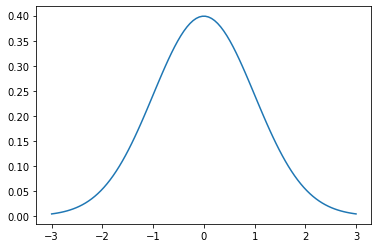

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [114]:
train_data[0]

'How did serfdom develop in and then leave Russia ?'

In [115]:
for i in X_train[0]:
    print(i)

  (0, 3786)	1
  (0, 2306)	1
  (0, 6747)	1
  (0, 2273)	1
  (0, 3888)	1
  (0, 509)	1
  (0, 7586)	1
  (0, 4390)	1
  (0, 6552)	1


In [116]:
print(X_train[0].toarray())

[[0 0 0 ... 0 0 0]]


In [120]:
for i, x in enumerate(X_train[0].toarray()[0]):
    if x > 0:
        print(i, count_vect.get_feature_names()[i])

509 and
2273 develop
2306 did
3786 how
3888 in
4390 leave
6552 russia
6747 serfdom
7586 then


In [121]:
count_vect.get_feature_names()

['000',
 '000th',
 '007',
 '10',
 '100',
 '103',
 '11',
 '111',
 '118',
 '11th',
 '12',
 '123',
 '126',
 '12601',
 '13',
 '134',
 '137',
 '139',
 '14',
 '142',
 '15',
 '155',
 '1562',
 '158',
 '15th',
 '16',
 '1603',
 '1642',
 '1649',
 '165',
 '1669',
 '167',
 '168',
 '1699',
 '16th',
 '17',
 '172',
 '173',
 '175',
 '1767',
 '177',
 '1779',
 '1781',
 '1787',
 '1789',
 '1797',
 '18',
 '1800s',
 '1812',
 '1815',
 '1830',
 '1832',
 '1834',
 '1835',
 '1842',
 '1847',
 '1849',
 '185',
 '1853',
 '1857',
 '1863',
 '1865',
 '1866',
 '1870',
 '1872',
 '1873',
 '1879',
 '187s',
 '188',
 '1880',
 '1881',
 '1885',
 '1886',
 '1891',
 '1892',
 '1893',
 '1895',
 '1896',
 '1898',
 '1899',
 '19',
 '1900s',
 '191',
 '1912',
 '1913',
 '1915',
 '1916',
 '1919',
 '192',
 '1920s',
 '1922',
 '1923',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '193',
 '1930s',
 '1931',
 '1932',
 '1933',
 '1935',
 '1936',
 '1937',
 '1939',
 '194',
 '1940',
 '1940s',
 '1941',
 '1942',
 '1943',
 '1945',
 '1946',
 '1948',
 '195